# Predicting Real Light Curve Classes with Pretrained Models

Welcome to the Gaia light curve prediction notebook! This notebook will guide you through the process of using pretrained deep learning models (ResNet) to classify real astronomical light curve data. You will learn how to:

- Prepare and preprocess real light curve data for prediction
- Load pretrained models and perform inference
- Interpret and visualize the classification results

Follow the steps below to predict the class (e.g., detached, overcontact, spot/nospot) of real Gaia light curves using the models trained on synthetic data.

### Download Gaia light curves

To download *Gaia G* light curves for objects from WUMaCat and DEBcat, follow this link: https://u.pcloud.link/publink/show?code=kZMm285Zoy7Q3IAQOakIshhv4jTeH8OAtS4y#folder=25535342132

You'll find the them in `SelectedLC\GAIA_DEB\` and `SelectedLC\GAIA_WUmaCAT\`. Download the LC folders, which contain Gaia G light curves in text format.

For additional information, please refer to our paper.

We put them in `gaia_real_data` directory. DEBcat as `detached` and WUMaCat as `overcontact`. 

### Read a Gaia ECSV light curve file using Astropy
Let's load a real Gaia light curve in ECSV format using Astropy's Table. This will allow us to inspect the data and prepare it for further processing.

In [1]:
from astropy.table import Table

# Example file path (update as needed|)
ecvs_path = '../data/gaia_real_data/detached/AI_Hya_3077483709857255808_p.ecvs'

table = Table.read(ecvs_path, format='ascii.ecsv')
display(table)

TimeG,FG,e_FG,Phase,norm_FG,e_norm_FG
,,,,,
float64,float64,float64,float64,float64,float64
2456956.297772,3622711,3183.114,0.5714,0.9962,0.0009
2456990.207451,3604943,10585.95,0.3340,0.9913,0.0029
2456990.281415,3617849,2315.054,0.3422,0.9949,0.0006
2457005.537853,3556450,2351.332,0.0350,0.9780,0.0006
2457005.713994,3558433,2842.105,0.0545,0.9785,0.0008
2457005.788034,3607184,3988.129,0.0627,0.9919,0.0011
2457134.047896,3560707,2490.186,0.2940,0.9792,0.0007
2457170.444805,3566926,2284.662,0.3325,0.9809,0.0006


The table contains the following columns:

- `TimeG`: Time of observation in Barycentric Julian Date (BJD).
- `FG`: Flux in the Gaia G band.
- `e_FG`: Error in the flux.
- `Phase`: Phase of the light curve.
- `norm_FG`: Normalized flux (on maximum).
- `e_norm_FG`: Error in the normalized flux.

### Plot a normalized, phase-folded Gaia light curve
Now let's visualize the normalized, phase-folded light curve from the ECSV file. 

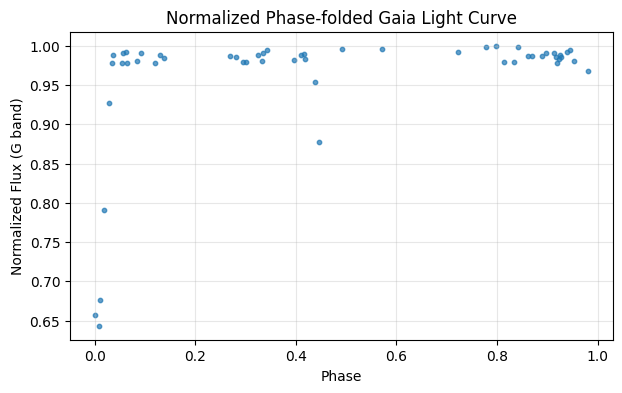

In [2]:
import matplotlib.pyplot as plt

# Plot phase vs normalized flux
plt.figure(figsize=(7, 4))
plt.scatter(table['Phase'], table['norm_FG'], s=10, alpha=0.7, color='tab:blue')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux (G band)')
plt.title('Normalized Phase-folded Gaia Light Curve')
plt.grid(True, alpha=0.3)
plt.show()

Now, you can imagine how the data looks like.
We will transform it to polar_hexbin representation and predict the class of the object using ResNet and ViT models. 

### Transform a real Gaia light curve to a polar hexbin image
We will use the function from `make_polar_hexbin_images.py` to convert the ECSV light curve to a polar hexbin PNG image, ready for model prediction.

In [3]:
import sys
sys.path.append('../scripts')
from make_polar_hexbin_images import create_polar_hexbin_from_ecsv

# Use the same ECSV file as before
image_path = create_polar_hexbin_from_ecsv(ecvs_path, out_dir="../data/gaia_real_data/detached/")
print(f"Saved polar hexbin image: {image_path}")

Saved polar hexbin image: ../data/gaia_real_data/detached/AI_Hya_3077483709857255808_p.png


### Download models from the cloud to use them.
We will use ResNet model trained for binary classification and spot detection. 
Follow again the link: https://u.pcloud.link/publink/show?code=kZMm285Zoy7Q3IAQOakIshhv4jTeH8OAtS4y#folder=25535342132
From `Models/Gaia/` download:
- 2class_binary_resnet_gaia_hexbin.pth
- 2class_detachspot_resnet_gaia_hexbin.pth
- 2class_overspot_resnet_gaia_hexbin.pth

Save them into `models` directory in your current workspace.

### Load a pretrained ResNet model and predict the class for a real Gaia object
We will load a pretrained ResNet model and use it to predict the class of the chosen real Gaia light curve, using the polar hexbin image we generated.

In [13]:
import sys
sys.path.append('../scripts')
from classify_pytorch_resnet import load_resnet_model, predict_image

# Path to the pretrained model (update if needed)
model_path = '../models/2class_binary_resnet_gaia_hexbin.pth'

# Load the model
model = load_resnet_model(model_path, num_classes=2)

# Predict the class for the generated image
predicted_class, probabilities = predict_image(model, image_path)
if predicted_class == 0:
    print("Predicted class: detached system")
elif predicted_class == 1:
    print("Predicted class: overcontact system")
print(f"Class probabilities: {probabilities}")

Predicted class: detached system
Class probabilities: [9.9999964e-01 4.0198546e-07]


### Predict spot existence for a detached system using the detachspot model
Since the predicted class is 0 (detached), we will now use the pretrained ResNet model for spot detection on detached systems to predict whether the object has spots.

In [15]:
# Path to the pretrained spot detection model for detached systems
spot_model_path = '../models/2class_detachspot_resnet_gaia_hexbin.pth'

# Load the spot detection model
spot_model = load_resnet_model(spot_model_path, num_classes=2)

# Predict spot/nospot for the same image
spot_class, spot_probabilities = predict_image(spot_model, image_path)
if spot_class == 0:
    print("Predicted: no spot")
elif spot_class == 1:
    print("Predicted: spot present")
print(f"Spot class probabilities: {spot_probabilities}")

Predicted: no spot
Spot class probabilities: [0.850407   0.14959295]


### Batch prediction for all real Gaia objects: system type and spot existence

This cell will:
- Iterate over all ECSV files in both `detached` and `overcontact` directories.
- For each object, generate a polar hexbin image (if not already present), predict the system class (detached/overcontact), and predict spot existence.
- Store results in two DataFrames: one for system classification, one for spot detection.
- Each DataFrame will have columns: `object`, `class`, `class_probability`, `spots`, `spot_probability`.

In [9]:
import os
import glob
import pandas as pd
import sys

sys.path.append('../scripts')
from make_polar_hexbin_images import create_polar_hexbin_from_ecsv
from classify_pytorch_resnet import load_resnet_model, predict_image

# Paths to models
class_model_path = '../models/2class_binary_resnet_gaia_hexbin.pth'
detachspot_model_path = '../models/2class_detachspot_resnet_gaia_hexbin.pth'
overspot_model_path = '../models/2class_overspot_resnet_gaia_hexbin.pth'

# Load models once
class_model = load_resnet_model(class_model_path, num_classes=2)
detachspot_model = load_resnet_model(detachspot_model_path, num_classes=2)
overspot_model = load_resnet_model(overspot_model_path, num_classes=2)

# Directories
base_dir = '../data/gaia_real_data'
dirs = ['detached', 'overcontact']

detached_results = []
overcontact_results = []

for system_type in dirs:
    ecsv_dir = os.path.join(base_dir, system_type)
    for ecsv_path in glob.glob(os.path.join(ecsv_dir, '*.ecvs')):
        # Object name is the part before the first '_'
        object_name = os.path.basename(ecsv_path).split('_')[0]
        if system_type == 'detached':
            object_name = '_'.join(os.path.basename(ecsv_path).split('_')[:2])
        # Generate image (will overwrite if exists)
        image_path = create_polar_hexbin_from_ecsv(ecsv_path, out_dir=ecsv_dir)
        # Predict system class
        pred_class, class_probs = predict_image(class_model, image_path)
        class_label = 'detached' if pred_class == 0 else 'overcontact'
        class_prob = class_probs[pred_class]
        # Prepare row for system classification
        row = {
            'object': object_name,
            'class': class_label,
            'class_probability': class_prob,
            'spots': None,
            'spot_probability': None
        }
        # Predict spots using the correct model
        if class_label == 'detached':
            spot_pred, spot_probs = predict_image(detachspot_model, image_path)
            spot_label = 'n' if spot_pred == 0 else 's'
            spot_prob = spot_probs[spot_pred]
            # Add spot info to row
            row['spots'] = spot_label
            row['spot_probability'] = spot_prob
            # Store in detached results    
        else:
            spot_pred, spot_probs = predict_image(overspot_model, image_path)
            spot_label = 'n' if spot_pred == 0 else 's'
            spot_prob = spot_probs[spot_pred]
            # Add spot info to row
            row['spots'] = spot_label
            row['spot_probability'] = spot_prob

        # Append row to the appropriate results list
        if system_type == 'detached':
            detached_results.append(row)
        else:
            overcontact_results.append(row)

    # Create DataFrames
    df_detached = pd.DataFrame(detached_results)
    df_overcontact = pd.DataFrame(overcontact_results)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# For detached systems
true_detached = ['detached'] * len(df_detached)
pred_detached = df_detached['class'].tolist()

acc_det = accuracy_score(true_detached, pred_detached)
prec_det = precision_score(true_detached, pred_detached, pos_label='detached')
rec_det = recall_score(true_detached, pred_detached, pos_label='detached')
f1_det = f1_score(true_detached, pred_detached, pos_label='detached')

print('Detached systems:')
print(f'Accuracy:  {acc_det:.3f}')
print(f'Precision: {prec_det:.3f}')
print(f'Recall:    {rec_det:.3f}')
print(f'F1-score:  {f1_det:.3f}')

# For overcontact systems
true_over = ['overcontact'] * len(df_overcontact)
pred_over = df_overcontact['class'].tolist()

acc_over = accuracy_score(true_over, pred_over)
prec_over = precision_score(true_over, pred_over, pos_label='overcontact')
rec_over = recall_score(true_over, pred_over, pos_label='overcontact')
f1_over = f1_score(true_over, pred_over, pos_label='overcontact')

print('\nOvercontact systems:')
print(f'Accuracy:  {acc_over:.3f}')
print(f'Precision: {prec_over:.3f}')
print(f'Recall:    {rec_over:.3f}')
print(f'F1-score:  {f1_over:.3f}')

Detached systems:
Accuracy:  1.000
Precision: 1.000
Recall:    1.000
F1-score:  1.000

Overcontact systems:
Accuracy:  0.820
Precision: 1.000
Recall:    0.820
F1-score:  0.901


### Cross-correlate predicted overcontact objects with WUMaCat catalog
We will compare the `object` column in `df_overcontact` with the `name` column in `classification_WUMaCat.csv` to find which predicted overcontact objects are not present in the catalog.

In [15]:
import pandas as pd

# Load the WUMaCat catalog
wumacat = pd.read_csv('../data/classification_WUMaCat.csv')

# Get the set of object names in the catalog
wumacat_names = set(wumacat['name'].astype(str))

# Get the set of predicted overcontact objects
overcontact_objects = set(df_overcontact['object'].astype(str))

# Find objects in df_overcontact not present in the catalog
not_in_catalog = sorted(list(overcontact_objects - wumacat_names))

print(f"Objects in df_overcontact not in classification_WUMaCat.csv: {not_in_catalog}")
print(f"Total missing: {len(not_in_catalog)}")

Objects in df_overcontact not in classification_WUMaCat.csv: ['BH Cas', 'BO CVn', 'CX Vir', 'DY Cet', 'ES Lib', 'GW Cnc', 'V2612 Oph', 'V502 Oph', 'V524 Mon', 'V829 Her']
Total missing: 10


### Print classification results for overcontact objects not in WUMaCat
Below are the predicted classes and probabilities for the overcontact objects missing from the WUMaCat catalog.

In [17]:
# Filter df_overcontact for objects not in the catalog
missing_df = df_overcontact[df_overcontact['object'].astype(str).isin(not_in_catalog)]
display(missing_df.sort_values(by='object'))

,object,class,class_probability,spots,spot_probability
73,BH Cas,overcontact,0.997387,s,0.996995
74,BO CVn,overcontact,0.999988,n,0.868481
88,CX Vir,overcontact,0.958007,s,0.500607
64,DY Cet,overcontact,0.999997,n,0.804314
0,ES Lib,detached,0.844277,n,0.797879
47,GW Cnc,overcontact,0.998182,s,0.500724
53,V2612 Oph,overcontact,0.986244,s,0.914510
92,V502 Oph,overcontact,0.998500,s,0.850837
76,V524 Mon,detached,0.868602,s,0.984493
79,V829 Her,overcontact,0.992190,s,0.850008


In [29]:
print(', '.join(df_overcontact[df_overcontact['class'] == 'detached']['object'].sort_values()))

1SWASP J150822.80-054236.9, AH Aur, AQ Psc, BX And, ES Lib, ET Leo, FT Lup, GZ And, HI Pup, QW Gem, SS Ari, TX Cnc, TYC 2675-663-1, V524 Mon, V592 Per, V728 Her, V870 Ara, Y Sex
